# Heatmap
### _Sample production notebook_
---
This notebook is intended to quickly produce heatmaps by utilizing parallel computation with dask. It will create intermediate files in the `data` directory in your current working directory.

#### Inputs
1. You will need a weights file. The weights file used in this sample is a `.csv` so it is loaded into a dictionary using pandas. See below under `Get weights`. This weights dictionary is of the format: `{run_id: weight}`
2. A list of your WSE grids from s3.

#### Outputs
1. `bool_hdf` directory: A directory containing intermediate boolean hdf files.
2. `weighted_chunks` directory: A directory containing hdf files of summed up weights by chunks. The number of files here will match the number of workers that were automatically set for your local cluster.
3. `results` directory: The output heatmap, and a clipped version _(only if your machine had enough memory to clip no data out of the raster)_.

## Import modules and define functions

In [1]:
# standard stack
import os
from time import time
from glob import glob
import sys; sys.path.append('../')

# dask
import dask
from dask.distributed import Client, LocalCluster
import dask.bag as db

# hecrasio core
from hecrasio.heatmap import *

%matplotlib inline

## Start the overall timer

In [2]:
overall_start = time()

## User Inputs

In [3]:
project = 'DC'
model = 'P06'
weights_path = r"C:\Users\abrazeau\Desktop\for_cluster\DC_P06_weights.csv"
wkdir = os.getcwd()

# A dictionary of the metadata to be associated with the heatmap result
# E.g. {'Projection': '4326', 'Project': project, 'Model': model}
heatmap_meta = {'':''}

### Manage paths based on the above inputs

In [4]:
output_folder_name = 'data_{}_{}'.format(project, model)
if not os.path.exists(os.path.join(wkdir, output_folder_name)):
    os.makedirs(os.path.join(wkdir, output_folder_name))
output_folder = os.path.join(wkdir, output_folder_name)
bool_dir = os.path.join(output_folder, 'bool_hdfs')
weighted_dir = os.path.join(output_folder, 'weighted_chunks')
heatmap_dir = os.path.join(output_folder, 'results')
outputTifname = '{}_{}_heatmap.tif'.format(project, model)
print('Outputs will be written to:', output_folder)

Outputs will be written to: C:\Users\abrazeau\Documents\GitHub\hecrasio\notebooks\data_DC_P06


### Load the weights file

In [5]:
import pandas as pd
weights_df = pd.read_csv(weights_path)
weights_dict = dict(zip(weights_df.event_id, weights_df.weight))
weights_df['event_id'] = weights_df.event_id.apply(lambda x: x.replace('Base', 'NBR'))
for i in range(5):
    print(list(weights_dict.keys())[i], ':', list(weights_dict.values())[i])

H06_E0001 : 0.0029143543641936124
H06_E0002 : 0.002590537212616544
H06_E0003 : 0.0024980180264516675
H06_E0004 : 0.002405498840286791
H06_E0005 : 0.0023592392472043533


### Get a list of the WSE grids

In [6]:
wse_grids = s3List("pfra", "{}/{}".format(project, model), "", ".tif")
wse_grids = [x for x in wse_grids if 'WSE' in x]
len(wse_grids)

959

#### Specify the number of necessary chunks based on the estimated size of the in-memory arrays

In [7]:
num_chunks, num_workers = get_num_chunks_local(wse_grids[0])

Opening this raster will equate to roughly 0.17 GB in memory.
Using 10 for the number of chunks.
Using 20 for the number of workers.


### Set up the Local cluster

In [8]:
cluster = LocalCluster(n_workers=num_workers)
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:62146 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 20 Cores: 20 Memory: 34.21 GB


### Use dask to make boolean hdf files

In [9]:
st = time()

daskb = db.from_sequence(wse_grids)
res = daskb.map(daskbag_bool_wse_hdf_local, bool_dir=bool_dir, num_chunks=num_chunks)
res.compute()

print(round((time() - st)/60, 2), 'minutes to run')

5.13 minutes to run


### Use dask to create a weighted grid hdf file for each chunk

In [10]:
st = time()

chunkbag = db.from_sequence(range(num_chunks))
res2 = chunkbag.map(write_weighted_chunks_local, 
                    weights_dict=weights_dict,
                    bool_dir=bool_dir,
                    weighted_dir=weighted_dir)
res2.compute()

print(round((time() - st)/60, 2), 'minutes to run')

2.9 minutes to run


### Create a heatmap for the whole area
#### List and sort the weighted chunks files that are local

In [11]:
weighted_hdfs = glob(os.path.join(weighted_dir, '*.hdf'))
list.sort(weighted_hdfs, key=lambda x: int(os.path.basename(x).split('_')[1]))
len(weighted_hdfs)

10

#### Download one of the WSE grids to use as a template

In [12]:
tifTemplate = get_s3template_tif(wse_grids)
print(tifTemplate)

WSE_DC_P06_H06_E0001.tif


### Create the actual heatmap from the weighted chunks

In [13]:
st = time()

writeTifByChunks_local(tifTemplate, outputTifname, weighted_hdfs, heatmap_dir)
result = os.path.join(heatmap_dir, outputTifname)
update_tif_metadata(result, heatmap_meta)

print(round((time() - st)/60, 2), 'minutes to run')

C:\Users\abrazeau\Documents\GitHub\hecrasio\notebooks\data_DC_P06\results\DC_P06_heatmap.tif has been written!
0.05 minutes to run


### Clip the raster to only include areas with data

In [14]:
if enough_mem_to_clip(result):
    crop_path = result.replace('.tif', '_clip.tif')
    clip_off_nodatas(result, crop_path)

### Plot the result

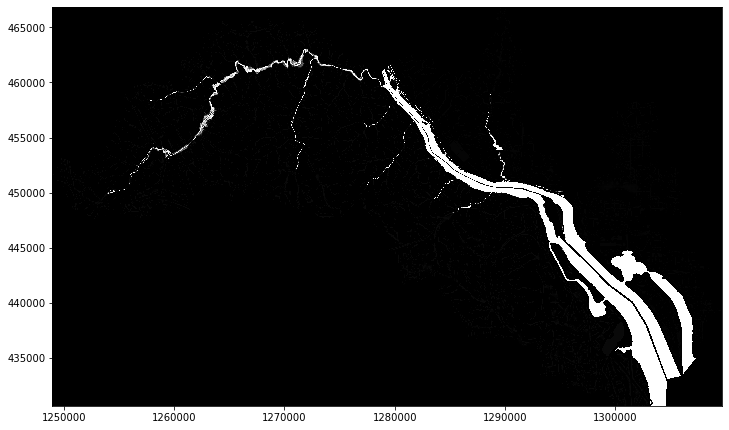

In [15]:
from rasterio.plot import show
from matplotlib import pyplot

try:
    if enough_mem_to_clip(result):
        with rasterio.open(crop_path) as ras:
            fig, ax = pyplot.subplots(1, figsize=(12, 12))
            show((ras, 1), cmap='Greys_r')
    else:
        with rasterio.open(result) as ras:
            fig, ax = pyplot.subplots(1, figsize=(12, 12))
            show((ras, 1), cmap='Greys_r')
except MemoryError:
    print('The raster is too big to plot!')

### End the timer

In [16]:
os.remove(tifTemplate)
print(round((time() - overall_start)/60, 2), 'minutes to run')

8.37 minutes to run


# END